In [20]:
import numpy as np
import pandas as pd
import scipy.stats as stats
from jax.scipy.stats import norm as jnorm
import jax.numpy as jnp
from jax import grad
from DataSourcing import get_options_chain
import matplotlib.pyplot as plt


In [21]:
import pandas as pd
from jax.scipy.stats import norm as jnorm
import jax.numpy as jnp
from jax import grad

def black_scholes(S, K, T, r, sigma, otype):
    d1 = (jnp.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * jnp.sqrt(T))
    d2 = d1 - sigma * jnp.sqrt(T)
    if otype == 'CALL':
        return S * jnorm.cdf(d1) - K * jnp.exp(-r * T) * jnorm.cdf(d2)
    elif otype == 'PUT':
        return K * jnp.exp(-r * T) * jnorm.cdf(-d2) - S * jnorm.cdf(-d1)

def loss(S, K, T, r, sigma_guess, price, otype):
    theo = black_scholes(S, K, T, r, sigma_guess, otype)
    return theo - price

loss_grad = grad(loss, argnums=4)

def newton_raphson(S, K, T, r, price, otype, sigma_guess=0.2, iters=100, epsilon=1e-6):
    sigma = sigma_guess
    for i in range(iters):
        loss_value = loss(S, K, T, r, sigma, price, otype)
        
        # Check for NaN values in loss
        if jnp.isnan(loss_value):
            print(f"NaN encountered in loss at iteration {i}: S={S}, K={K}, T={T}, r={r}, price={price}, otype={otype}, sigma={sigma}")
            return jnp.nan
        
        if abs(loss_value) < epsilon:
            break
        
        grad_sigma = loss_grad(S, K, T, r, sigma, price, otype)
        
        # Check for NaN values in gradient
        if jnp.isnan(grad_sigma):
            print(f"NaN encountered in gradient at iteration {i}: S={S}, K={K}, T={T}, r={r}, price={price}, otype={otype}, sigma={sigma}")
            return jnp.nan
        
        if grad_sigma == 0:
            print(f"Gradient is zero at iteration {i}, stopping early.")
            break
        
        sigma = sigma - loss_value / grad_sigma
        
        # Debugging output
        print(f"Iteration {i}: sigma={sigma}, loss={loss_value}, grad={grad_sigma}")
        
    return sigma

In [22]:
ivs = []
moneyness = []
dtes = []

opts_chain = get_options_chain('AAPL')
opts_chain.shape
opts_chain.head()

,expiryDate,optionType,strike,lastPrice,bid,ask,volume,openInterest,underlyingPrice,timeToExpiry,riskFreeRate,dayPrice
0,2025-09-19,CALL,175.0,67.61,64.90,65.35,20.0,493,232.919998,0.676712,4.213,232.919998
1,2026-01-16,CALL,265.0,13.83,13.30,13.50,37.0,3096,232.919998,1.002740,4.213,232.919998
2,2025-03-21,PUT,150.0,0.25,0.26,0.28,11.0,9342,232.919998,0.178082,4.213,232.919998
3,2025-02-28,CALL,225.0,13.50,13.40,13.50,3.0,51,232.919998,0.120548,4.213,232.919998
4,2025-02-07,CALL,280.0,0.10,0.09,0.10,15.0,683,232.919998,0.063014,4.213,232.919998


In [23]:
for index, row in opts_chain.iterrows():
    data = row.to_dict()
    S = data['underlyingPrice']
    K = data['strike']
    T = data['timeToExpiry']
    r = data['riskFreeRate']

    price = data['lastPrice']
    otype = data['optionType']

    iv = newton_raphson(S, K, T, r, price, otype)

    if iv is not None and iv > 0:
        ivs.append(iv)
        moneyness.append(S / K if otype == 'CALL' else K / S)
        dtes.append(T)
    else:
        print(f"Invalid implied volatility for row {index}: {iv}")



Gradient is zero at iteration 0, stopping early.
Gradient is zero at iteration 0, stopping early.
Gradient is zero at iteration 0, stopping early.
Iteration 0: sigma=-61003580571648.0, loss=84.02020263671875, grad=1.3772995331035043e-12
Gradient is zero at iteration 1, stopping early.
Invalid implied volatility for row 3: -61003580571648.0
Iteration 0: sigma=-2.8497278690338135, loss=18.35297203063965, grad=6.017904758453369
Iteration 1: sigma=-0.2662808895111084, loss=-53.92266082763672, grad=20.87236976623535
Iteration 2: sigma=-0.1810959428548813, loss=-0.9086567163467407, grad=10.666869163513184
Iteration 3: sigma=-0.12594226002693176, loss=-0.24871882796287537, grad=4.5095601081848145
Iteration 4: sigma=0.010521218180656433, loss=-0.11123249679803848, grad=0.8151081800460815
Gradient is zero at iteration 5, stopping early.
Iteration 0: sigma=-7.132611334168297e+28, loss=65.32904052734375, grad=9.159203777385681e-28
NaN encountered in gradient at iteration 1: S=232.9199981689453, K

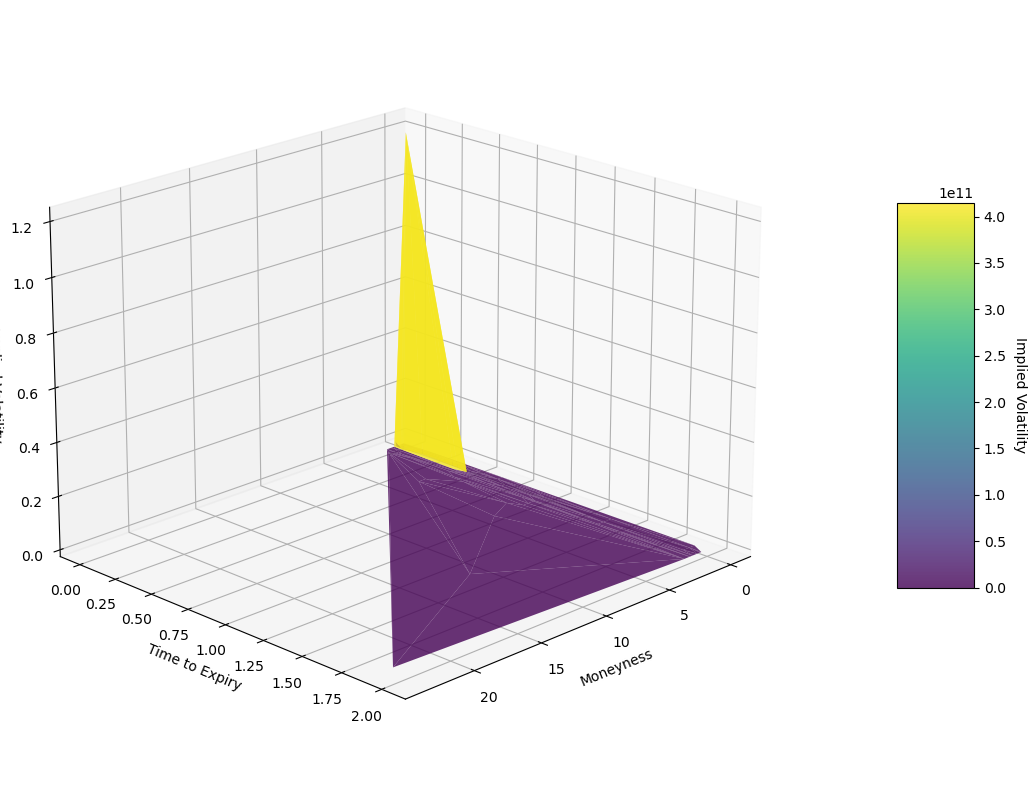

In [24]:
fig = plt.figure(figsize=(12, 8), dpi=100)
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_trisurf(moneyness, dtes, ivs, cmap='viridis', linewidth=0.1, antialiased=True, alpha=0.8)

cbar = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5, pad=0.1)
cbar.set_label('Implied Volatility', rotation=270, labelpad=15)

ax.set_xlabel('Moneyness')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Implied Volatility')

ax.view_init(20, 45)

plt.tight_layout()
plt.show()





